In [ ]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sn
from kagglehub import dataset_download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


In [ ]:
def get_sentiment(text):
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
sia = SentimentIntensityAnalyzer()


In [ ]:
def load_and_preprocess_dataset(dataset_name):
    dataset_dir = dataset_download(dataset_name)
    csv_file_path = None
    for filename in os.listdir(dataset_dir):
        if filename.endswith(".csv"):
            csv_file_path = os.path.join(dataset_dir, filename)
            break
    if csv_file_path:
        df = pd.read_csv(csv_file_path)
        required_columns = ["date", "favorite_count", "followers_count", "friends_count",
                            "full_text", "retweet_count", "screen_name", "tweet_id",
                            "user_id"]
        if all(col in df.columns for col in required_columns):
            df = df[required_columns]
            df['clean_text'] = df['full_text'].apply(clean_text)
            df['sentiment'] = df['clean_text'].apply(get_sentiment)
            return df
        else:
            print("Error: Dataset is missing required columns.")
            return None
    else:
        print("Error: No CSV file found in dataset.")
        return None

In [ ]:
dataset_name = "cpluzshrijayan/swiggy-tweet"
df = load_and_preprocess_dataset(dataset_name)


In [ ]:
df.head()

,date,favorite_count,followers_count,friends_count,full_text,retweet_count,screen_name,tweet_id,user_id,clean_text,sentiment
0,7/18/2019 22:47,0,82,219,@Mahi_2510 @swiggy_in The ultimate answer will...,0,syamantak1,1,"6,19,59,419",ultimate answer b sorry assure,Positive
1,7/18/2019 22:43,0,102,129,@SwiggyCares I hope so.,0,Bharatbbhushn,2,"14,32,84,383",hope,Positive
2,7/18/2019 22:37,0,102,129,@SwiggyCares I think you have the order detail...,0,Bharatbbhushn,3,"14,32,84,383",think order detail number present yea call right,Positive
3,7/18/2019 22:35,0,13,16,"@swiggy_in People are complaining here also, i...",0,taifkhalid01,4,"8,30,34,00,00,00,00,00,000",people complaining also know little disappoint...,Negative
4,7/18/2019 22:25,0,102,129,@SwiggyCares Do you even know the meaning of y...,0,Bharatbbhushn,5,"14,32,84,383",even know meaning tagline dm wont work want ex...,Negative


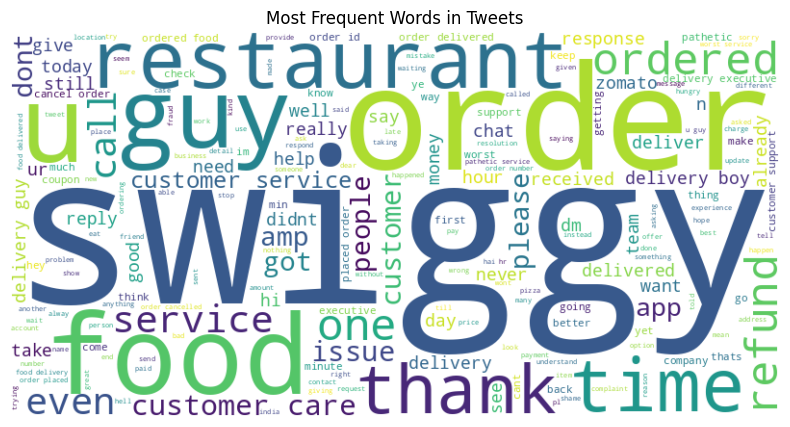

In [ ]:
def plot_word_cloud(text_data):
    text = " ".join(text_data)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Frequent Words in Tweets")
    plt.show()

plot_word_cloud(df['clean_text'])

<ipython-input-74-abddbdfb6ff4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot(x=sentiments, palette="coolwarm")


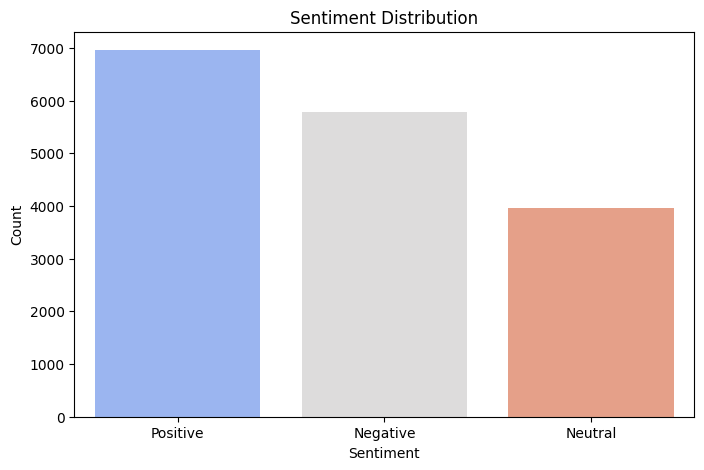

In [ ]:
def plot_sentiment_distribution(sentiments):
    plt.figure(figsize=(8, 5))
    sn.countplot(x=sentiments, palette="coolwarm")
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

plot_sentiment_distribution(df['sentiment'])



In [ ]:


if df is not None:
    # Tokenization & Preprocessing
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(df['clean_text'])
    sequences = tokenizer.texts_to_sequences(df['clean_text'])
    X = pad_sequences(sequences, maxlen=100)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['sentiment'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Optimized Model Definition
    model = Sequential([
        Embedding(input_dim=5000, output_dim=64, input_length=100),
        BatchNormalization(),
        Bidirectional(LSTM(64, dropout=0.7, return_sequences=False)),  # Higher dropout
        Dense(3, activation='softmax', kernel_regularizer=l2(0.02))  # Higher L2 regularization
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Stricter Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # Train Model & Capture History
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Predictions & Classification Report
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.4689 - loss: 1.0826 - val_accuracy: 0.2973 - val_loss: 1.5914
Epoch 2/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.7432 - loss: 0.6548 - val_accuracy: 0.8232 - val_loss: 0.5470
Epoch 3/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 54s 129ms/step - accuracy: 0.8417 - loss: 0.4584 - val_accuracy: 0.8567 - val_loss: 0.4824
Epoch 4/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - accuracy: 0.8794 - loss: 0.3721 - val_accuracy: 0.8588 - val_loss: 0.4728
Epoch 5/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 52s 125ms/step - accuracy: 0.8959 - loss: 0.3386 - val_accuracy: 0.8579 - val_loss: 0.4739
Epoch 6/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 55s 132ms/step - accuracy: 0.8964 - loss: 0.3302 - val_accuracy: 0.8537 - val_loss: 0.4761
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
              precision    recall  f1-score   support

    Negative       0.85      0.84      0.85      1192
     Neutral       0.90      0.84      0.87       770
    Posit

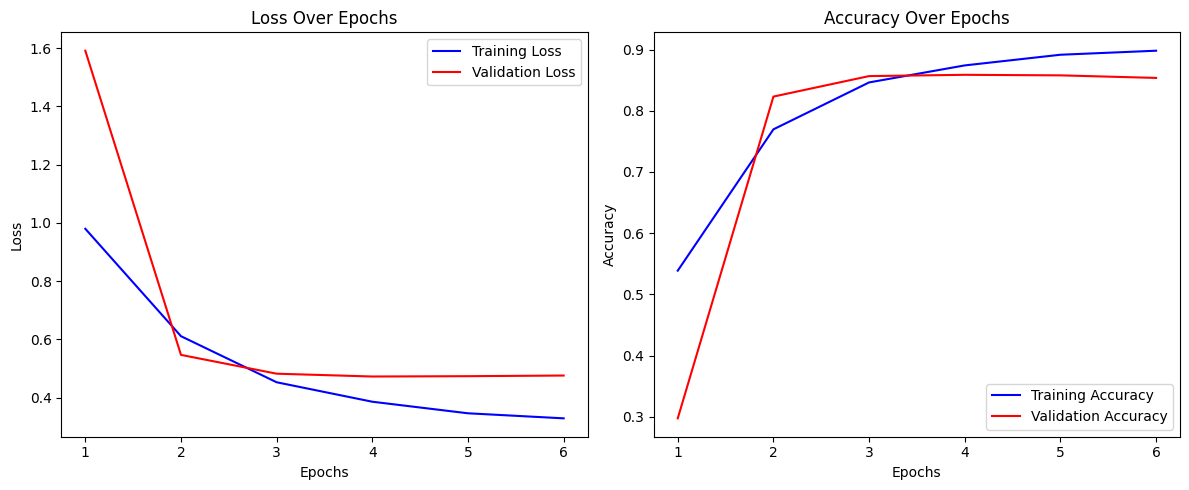

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history.history.get('val_loss', []), 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history.history.get('val_accuracy', []), 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm")

def extract_named_entities(text_data):
    entities = {"ORG": [], "GPE": [], "PRODUCT": []}
    for text in text_data:
        doc = nlp(text)
        for ent in doc.ents:
            if ent.label_ in entities:
                entities[ent.label_].append(ent.text)

    for entity_type, values in entities.items():
        values = list(set(values))[:10]  # Get unique top 10
        print(f"{entity_type}: {values}")

extract_named_entities(df['clean_text'])

ORG: ['mehsana city gujarati', 'faketan customer care got mail escalation team', 'sanjayavikamcom', 'google', 'mumbai friend', 'resolution customer service fake', 'swiggy u r super', 'super', 'hwre moron cheated', 'grt']
GPE: ['hitech city', 'resi', 'kalamandir', 'kaati', 'nobrand', 'anuj', 'maine', 'china', 'rajauri', 'hhdje']
PRODUCT: ['dinneri', 'slogon', 'google', 'tanvir', 'jahan', 'swiggy supper', 'mai lgatar', 'coke coke', 'swiggy hour', 'kada']


In [ ]:
def topic_modeling(text_data, num_topics=5):
    vectorizer = CountVectorizer(stop_words="english")
    text_matrix = vectorizer.fit_transform(text_data)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(text_matrix)

    words = vectorizer.get_feature_names_out()
    for i, topic in enumerate(lda.components_):
        top_words = [words[i] for i in topic.argsort()[-10:]]
        print(f"Topic {i+1}: {', '.join(top_words)}")

topic_modeling(df['clean_text'])

Topic 1: ur, dont, check, veg, ordered, swiggy, time, delivery, dm, food
Topic 2: restaurant, ordered, min, time, food, swiggy, hour, delivered, delivery, order
Topic 3: guy, issue, day, got, ordered, money, food, order, refund, swiggy
Topic 4: dont, chat, support, food, guy, care, order, swiggy, service, customer
Topic 5: dont, service, guy, boy, price, food, charge, swiggy, restaurant, delivery
